In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [3]:
for gpu in gpus:
    print(gpu)

In [6]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [7]:
ds = tfds.load('fashion_mnist', split='train')

2024-10-01 22:20:07.155181: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

2024-10-01 22:20:18.362393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shuffling /home/kalil/tensorflow_datasets/fashion_mnist/3.0.1.incomplete363WT6/fashion_mnist-train.tfrecord*..…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/kalil/tensorflow_datasets/fashion_mnist/3.0.1.incomplete363WT6/fashion_mnist-test.tfrecord*...…

Dataset fashion_mnist downloaded and prepared to /home/kalil/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
import numpy as np

In [9]:
dataiterator = ds.as_numpy_iterator()

In [12]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

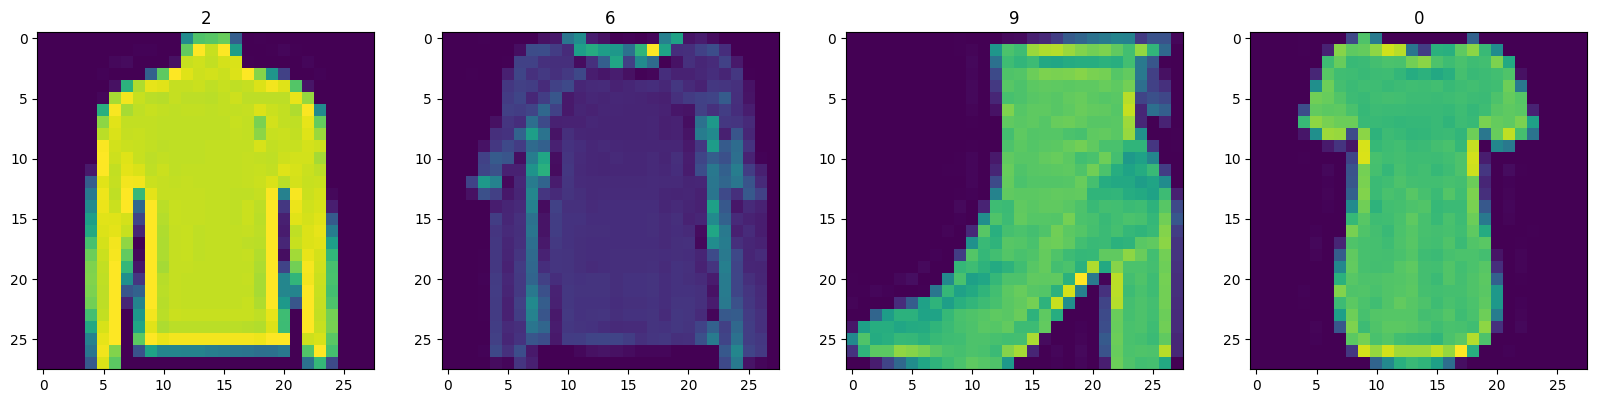

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [17]:
def scale_images(data):
    image = data['image']
    return image/255

In [20]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [22]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D


Build Generator

In [43]:
def build_generator():
    model = Sequential()
    # Takes in random values and reshape it to 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to ome channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [50]:
generator = build_generator()

In [51]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

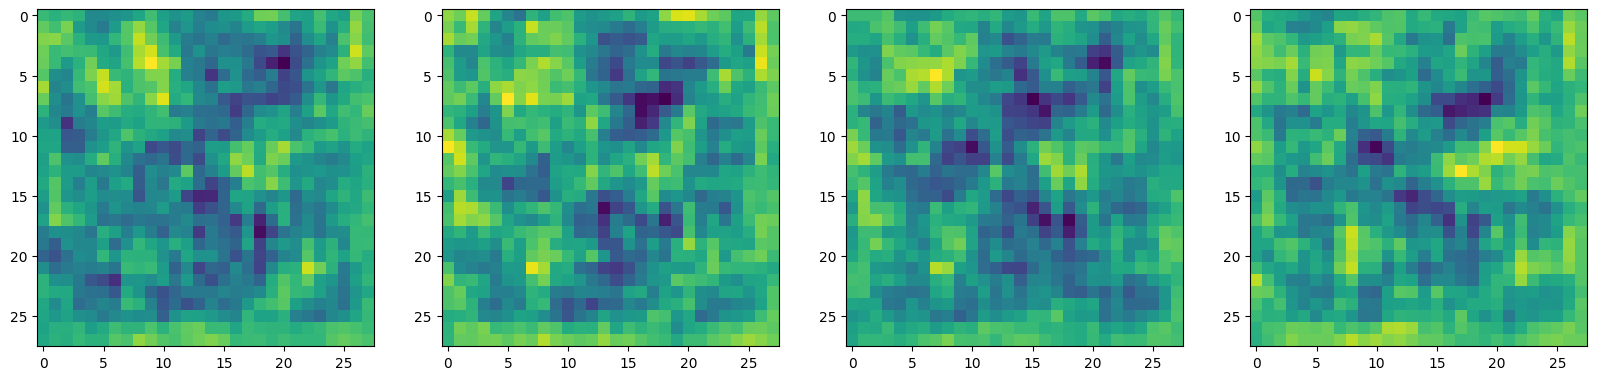

In [55]:
img = generator(np.random.rand(4, 128, 1))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    ax[idx].imshow(np.squeeze(img[idx]))




1/1 [==============================] - 0s 49ms/step


(28, 28, 1)

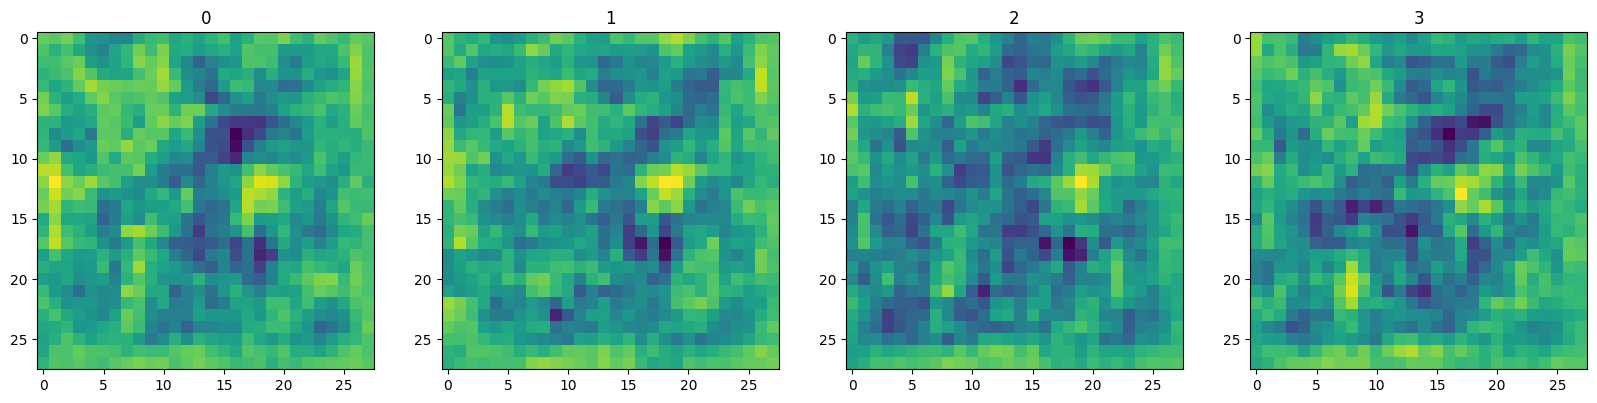

In [82]:
img = generator.predict(np.random.rand(4, 128, 1))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

Build Discriminator

In [77]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass tp dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [78]:
discriminator = build_discriminator()

In [79]:
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_17 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 128)     

In [83]:
img = generator(np.random.rand(4, 128, 1))

In [84]:
img.shape

TensorShape([4, 28, 28, 1])

In [87]:
discriminator.predict(img)

1/1 [==============================] - 0s 27ms/step


array([[0.50601846],
       [0.50602955],
       [0.5060219 ],
       [0.5059918 ]], dtype=float32)

In [88]:
first = img[0]
discriminator.predict(np.expand_dims(first, axis=0))

1/1 [==============================] - 0s 19ms/step


array([[0.50601846]], dtype=float32)

Setup Losses and Optimizers

In [89]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [90]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build Subclassed Model

In [91]:
from tensorflow.keras.models import Model

In [112]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)


        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {'d_loss': total_d_loss, 'g_loss': total_g_loss}

In [113]:
fashgan = FashionGAN(generator, discriminator)

In [114]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [2]:
import os
import tensorflow.keras.preprocessing.image as array_to_img
import tensorflow.keras.callbacks as Callback

2024-10-02 00:03:07.803404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 00:03:09.905232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-02 00:03:09.905372: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-02 00:03:16.103320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

KeyboardInterrupt: 

In [1]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors, training=False)
        generated_images = 255
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('generated_images', f'generated_img_{epoch}_{i}.png'))

NameError: name 'Callback' is not defined

In [116]:
hist = fashgan.fit(ds, epochs=10)

Epoch 1/10


2024-10-01 23:54:02.975058: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2024-10-01 23:54:02.997655: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2024-10-01 23:54:03.056684: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2024-10-01 23:54:03.142201: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2024-10-01 23:54:03.822508: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.


  7/469 [..............................] - ETA: 1:34:43 - d_loss: 0.6947 - g_loss: 0.6955

KeyboardInterrupt: 